In [1]:
import tensorflow as tf
import numpy as np
import logging
import matplotlib.pyplot as plt
from tqdm import tqdm 
import pickle

print(tf.__version__)


2.12.0


# Mnist dataset

In [2]:
# Load MNIST test set
_,mnist_testset = tf.keras.datasets.mnist.load_data()

# Preprocessing transformation
transform = tf.keras.models.Sequential([
    tf.keras.layers.Reshape(target_shape=(28,28,1)),
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255)
])

# Apply transformation to test set
mnist_testset = (transform(mnist_testset[0]), mnist_testset[1])

# Create TensorFlow dataset from test set
test_dataset = tf.data.Dataset.from_tensor_slices(mnist_testset)
test_dataset = test_dataset.batch(1).shuffle(buffer_size=len(mnist_testset[0]))



11490434/11490434 [==============================] - 0s 0us/step


In [3]:
test_loader = iter(test_dataset)
data , target = next(iter(test_loader))
data.shape

TensorShape([1, 28, 28, 1])

# LeNet-5 Model

구조
* Conv2D with 10 kernels of size 5x5, 패딩 없음 
* MaxPooling2D (크기 2x2)
* Conv2D with 20 kernels of size 5x5, 패딩 없음
* Dropout
* MaxPooling2D (크기 2x2)
* Dense with 출력노드 50개
* Dense with 출력노드 ?개

In [4]:
class Net(tf.keras.Model):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(10, kernel_size=5, padding='valid')
        self.conv2 = tf.keras.layers.Conv2D(20, kernel_size=5, padding='valid')
        self.conv2_drop = tf.keras.layers.Dropout(0.5)
        self.fc1 = tf.keras.layers.Dense(50)
        self.fc2 = tf.keras.layers.Dense(10)

    def call(self, x, training=False):
        x = self.conv1(x) 
        x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
        x = tf.nn.relu(x)        
        x = self.conv2(x)
        if training:
            x = self.conv2_drop(x, training=training)
        x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
        x = tf.nn.relu(x)
        x = tf.transpose(x, (0, 3, 1, 2))
        x = tf.reshape(x, (-1, 320))
        x = self.fc1(x)
        x = tf.nn.relu(x)
        if training:
            x = tf.keras.layers.Dropout(0.5)(x, training=training)
        x = self.fc2(x)
        return x

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# load the network
model = Net()
model.build(input_shape=(None, 28, 28, 1))

with open('drive/MyDrive/Test/LIG/lenet5.pkl', 'rb') as f:
    weights = pickle.load(f)
model.set_weights(weights[:])

# L-BFGS Attack
이 방법의 아이디어는 다음과 같은 최적화 문제를 해결하는 것입니다:

$min_{x_{adv}}d(x_{adv} , x) \; s.t.\; f(x_{adv}) = y_{target}$

이 방법은 준 뉴턴 최적화 방법인 L-BFGS를 사용하여 **가능한 가장 작은 공격 섭동**을 찾도록 설계되었습니다. 일반적으로 위 최적화 문제의 해법은 정확한 계산은 어려워 박스 제약 L-BFGS를 사용하여 근사치를 구합니다.

$ min_{x_{adv}} c*d(x_{adv} , x) + loss(x_{adv},y_{target}) s.t.\; x_{adv} \in [0,1]^n $

여기서 거리 d는 유클리디안 거리를 사용하며, 공격에 성공하는 섭동의 크기 c는 라인서치를 이용해서 찾습니다. 즉, 위 최적화 문제의 해, $x + r$을 찾았다고 하더라도 공격이 성공하여 $f(x_{adv}) = y_{target}$를 만족한다는 보장이 없기 때문에 여러 c의 값을 반복하여 시도해보고 그중 가장 작은 c의 값에 의한 섭동 r을 사용합니다.

c의 값은, 극단적으로 가령 0일 경우 $loss(x_{adv},y_{target})$만을 최소화 하기에 공격에 성공을 하며, 따라서 공격을 성공하는 c의 값 중 가장 작은 값을 찾는다.

In [7]:
from scipy.optimize import fmin_l_bfgs_b

class LBFGSAttack():
    """
    Class LBFGS attack L-BFGS-B to minimize the cross-entropy and the distance between the
    original and the adversary.
    """
    def __init__(self, model):
        self._adv = None  
        self.model = model
        # Init bounds for lbfgs algorithm
        self.bounds = (0, 1)
        self._output = None

    def __call__(self, data, target, epsilon=0.01, steps=10):
        self.data = data
        self.target = target
        
        # finding initial value for c        
        c = epsilon
        x0 = self.data.numpy().flatten().astype(np.float32)
        
        # Line search initialization
        # 우선, 공격에 성공하는 c의 값을 rough하게 epsilon에서부터 doubling해가면서 찾습니다.
        for i in range(30):
            c = 2 * c
            is_adversary = self._lbfgsb(x0, c, steps)
            
            if is_adversary:
                # print('Successful')
                break
            
        if not is_adversary:
            return self._adv
        
        # Binary search c
        # 그 다음, 좀더 정밀하게 이진탐색을 통해 공격에 성공하는 최소 c값을 찾습니다.
        c_low = 0
        c_high = c
    
        while c_high - c_low >= epsilon:
            
            c_half = (c_low + c_high) / 2
            is_adversary = self._lbfgsb(x0, c_half, steps)
            if is_adversary:
                c_high = c_high - epsilon
            else:
                c_low = c_half
                
    def _loss(self, adv_x, c):
        adv = tf.convert_to_tensor(adv_x.reshape(self.data.shape), dtype=tf.float32)
        adv = tf.Variable(adv, trainable=True)

        with tf.GradientTape() as tape:
            output = self.model(adv)

            ce = tf.keras.losses.sparse_categorical_crossentropy(self.target, output, from_logits=True)
            ce = tf.reduce_mean(ce)
            d = tf.reduce_sum(tf.square(self.data - adv))
            loss = c * ce + d

        gradients = tape.gradient(loss, adv)
        grad_ret = tf.reshape(gradients, [-1]).numpy().astype(float)
        loss = loss.numpy().astype(float)

        return loss, grad_ret

    def _lbfgsb(self, x0, c, maxiter):
        
        min_, max_ = self.bounds
        bounds = [(min_, max_)] * len(x0)
        approx_grad_eps = (max_ - min_) / 100.0
        
        x, f, d = fmin_l_bfgs_b( # self._loss 를 최소화하는 x값, 
            self._loss,
            x0,
            args=(c, ),
            bounds=bounds,
            maxiter=maxiter,
            epsilon=approx_grad_eps)
        
        # 최대, 최소 경계를 넘어가는 경우 그냥 CLIPPING
        if np.amax(x) > max_ or np.amin(x) < min_:
            x = np.clip(x, min_, max_)
        adv = tf.convert_to_tensor(x.reshape(self.data.shape), dtype=tf.float32)
        
        output = self.model(adv)
        adv_label = tf.argmax(output, axis=1)
        logging.info('target_label = {}, adv_label={}'.format(self.target, adv_label))
        self._adv = adv
        self._output = output
        return adv_label.numpy().item() == self.target.numpy().item()

In [8]:
test_loader = iter(test_dataset)
data_origin, label_origin = next(iter(test_loader))

lbfgs = LBFGSAttack(model,)

lbfgs(data_origin, tf.ones(1), epsilon=0.01)

adv = lbfgs._adv

label_adv = tf.argmax(model(adv), axis=1)

#proba_original = tf.reduce_max(model(data)).numpy()*100
proba_adv = tf.reduce_max(tf.nn.softmax(lbfgs._output), axis=1).numpy() * 100



모델이 예측한 원래 이미지의 라벨: tf.Tensor([8], shape=(1,), dtype=int64)
데이터상 원래 이미지 라벨 tf.Tensor([8], shape=(1,), dtype=uint8)



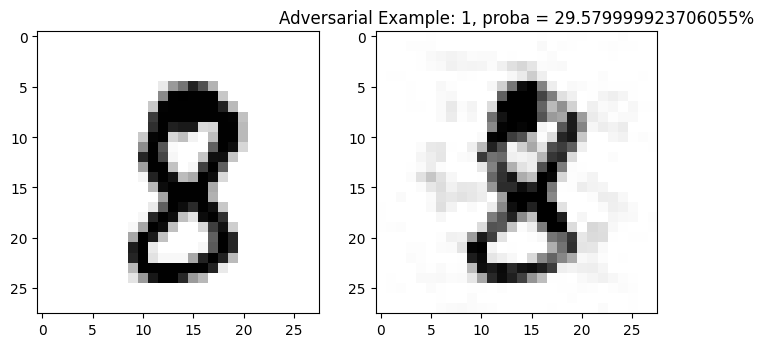

In [9]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True' #plt 실행할 때 kernel dead되는 것을 방지
print("")
print("모델이 예측한 원래 이미지의 라벨:",tf.argmax(model(data_origin),axis=1))
print("데이터상 원래 이미지 라벨",label_origin)
print("")

fig, ax = plt.subplots(1, 2, figsize=(8, 10))

# Adversarial Example 그리기 
adv = tf.reshape(adv,(28,28))
ax[1].imshow(adv, cmap='Greys')
ax[1].set_title("Adversarial Example: {}, proba = {}%".format(label_adv.numpy()[0],
                                                               round(proba_adv[0], 2)))
# Original data 그리기
data = tf.reshape(data_origin,(28,28))
ax[0].imshow(data, cmap='Greys')
#ax[0].set_title("Original image: {}, proba = {}%".format(target.numpy()[0], round(proba_original, 2)))

# Quiz

목표 레이블을 1에서 9로 바꾸어 가며 L-BFGS공격을 하여 적대적공격샘플과 공격 성공여부를 확인해보세요.

# Answer

lbfgs 호출 (`__call__`)함수의 인자로 target label을 지정해서 건네줍니다.

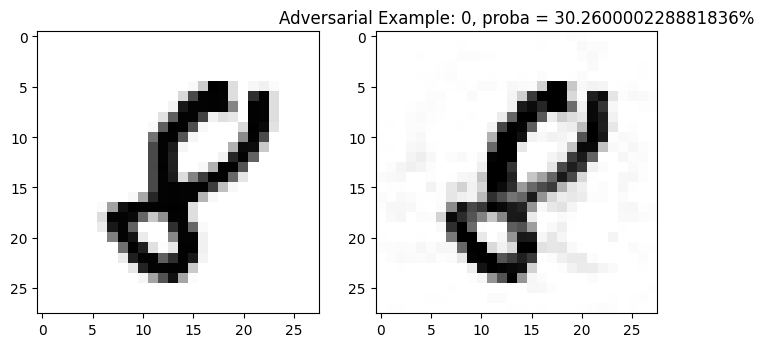

0


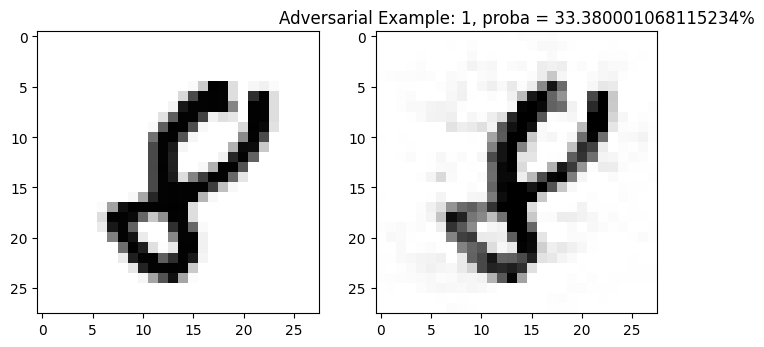

1


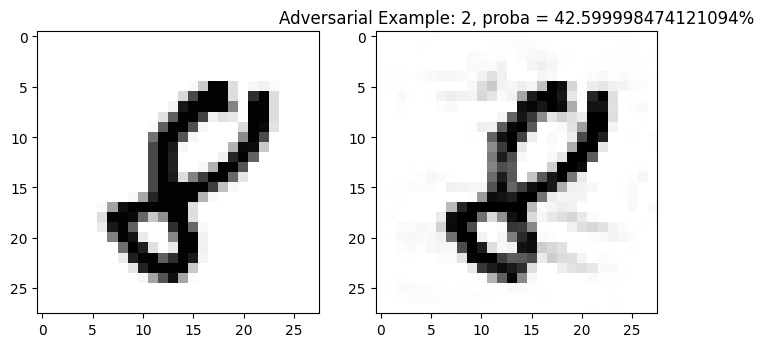

2


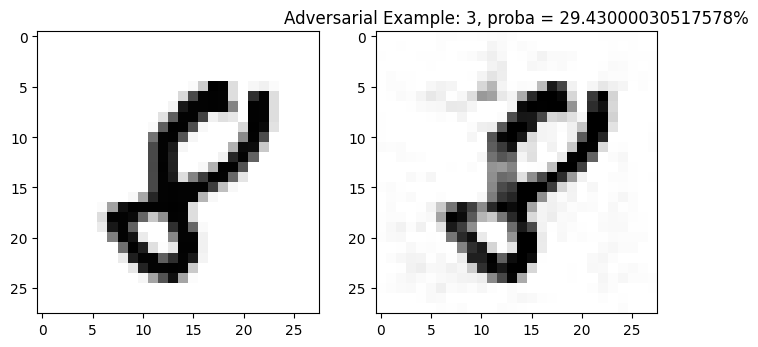

3


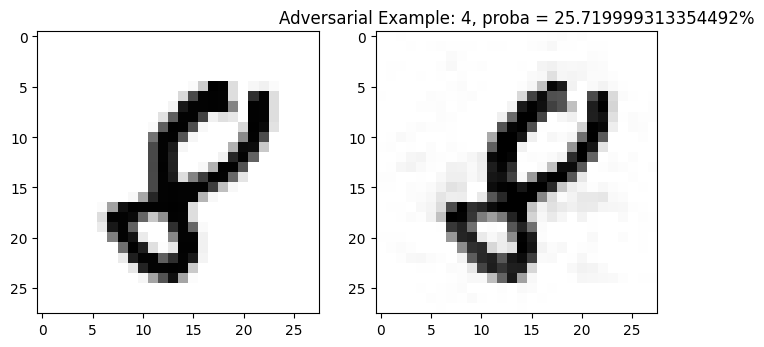

4


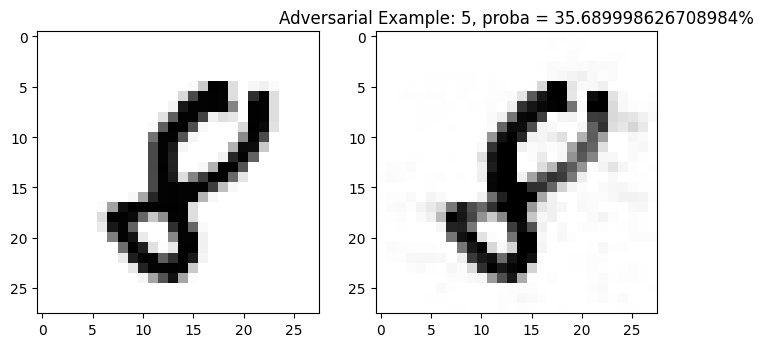

5


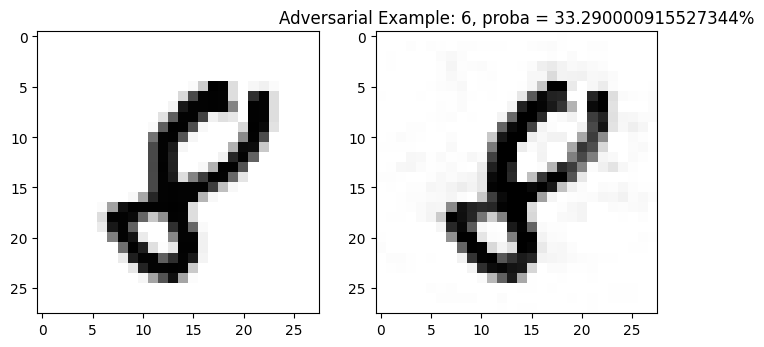

6


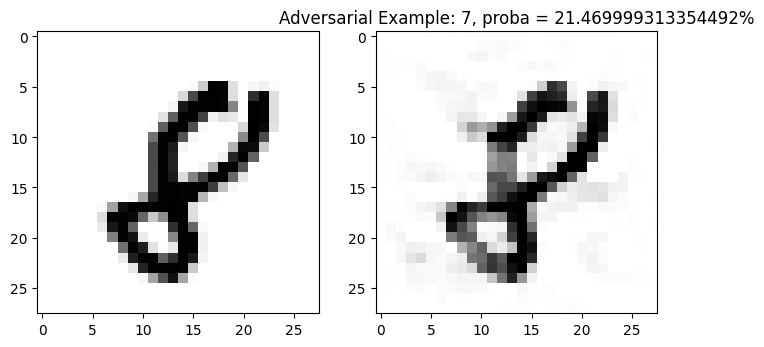

7


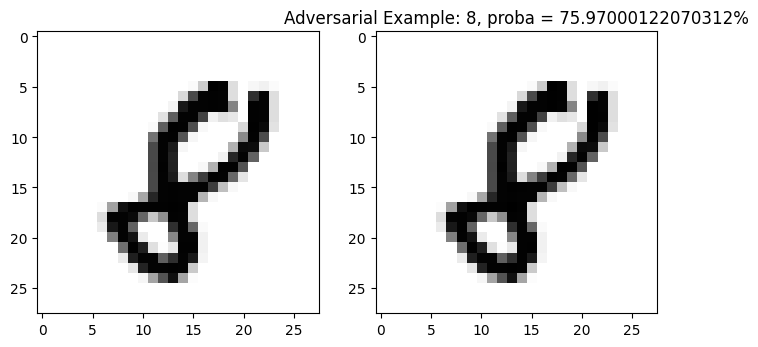

8


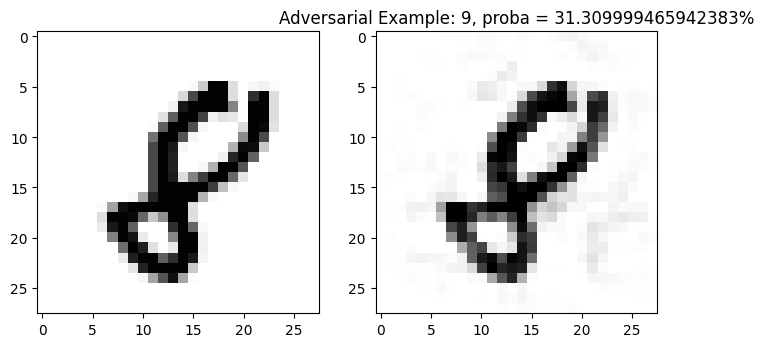

9


In [28]:
test_loader = iter(test_dataset)
data_origin, label_origin = next(iter(test_loader))

lbfgs = LBFGSAttack(model,)


for target_label in range(10):
    
    lbfgs(data_origin, tf.ones(1) * target_label, epsilon=0.01)

    adv = lbfgs._adv

    label_adv = tf.argmax(model(adv), axis=1)

    #proba_original = tf.reduce_max(model(data)).numpy()*100
    proba_adv = tf.reduce_max(tf.nn.softmax(lbfgs._output), axis=1).numpy() * 100
    
    fig, ax = plt.subplots(1, 2, figsize=(8, 10))

    # Adversarial Example 그리기 
    adv = tf.reshape(adv,(28,28))
    ax[1].imshow(adv, cmap='Greys')
    ax[1].set_title("Adversarial Example: {}, proba = {}%".format(label_adv.numpy()[0],
                                                                   round(proba_adv[0], 2)))
    # Original data 그리기
    data = tf.reshape(data_origin,(28,28))
    ax[0].imshow(data, cmap='Greys')
    #ax[0].set_title("Original image: {}, proba = {}%".format(target.numpy()[0], round(proba_original, 2)))
    
    # fig.show()
    plt.show()
    print(target_label)